In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
import shap

In [2]:
# Load dataset
df = pd.read_csv("apple_quality.csv")

# Display basic information about the dataset
print(df.head())
print(df.info())

   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-nu

In [3]:
# Clean the data
def clean_data(df):
    df = df.drop(columns=['A_id'])
    df = df.dropna()
    df = df.astype({'Acidity': 'float64'})

    def label(Quality):
        if Quality == "good":
            return 0
        if Quality == "bad":
            return 1
        return None

    df['Label'] = df['Quality'].apply(label)
    df = df.drop(columns=['Quality'])
    df = df.astype({'Label': 'int64'})
    return df

df_clean = clean_data(df.copy())
print(df_clean.head())

       Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840 -0.491590   
1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530 -0.722809   
2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033  2.621636   
3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  0.790723   
4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849  0.501984   

   Label  
0      0  
1      0  
2      1  
3      0  
4      0  


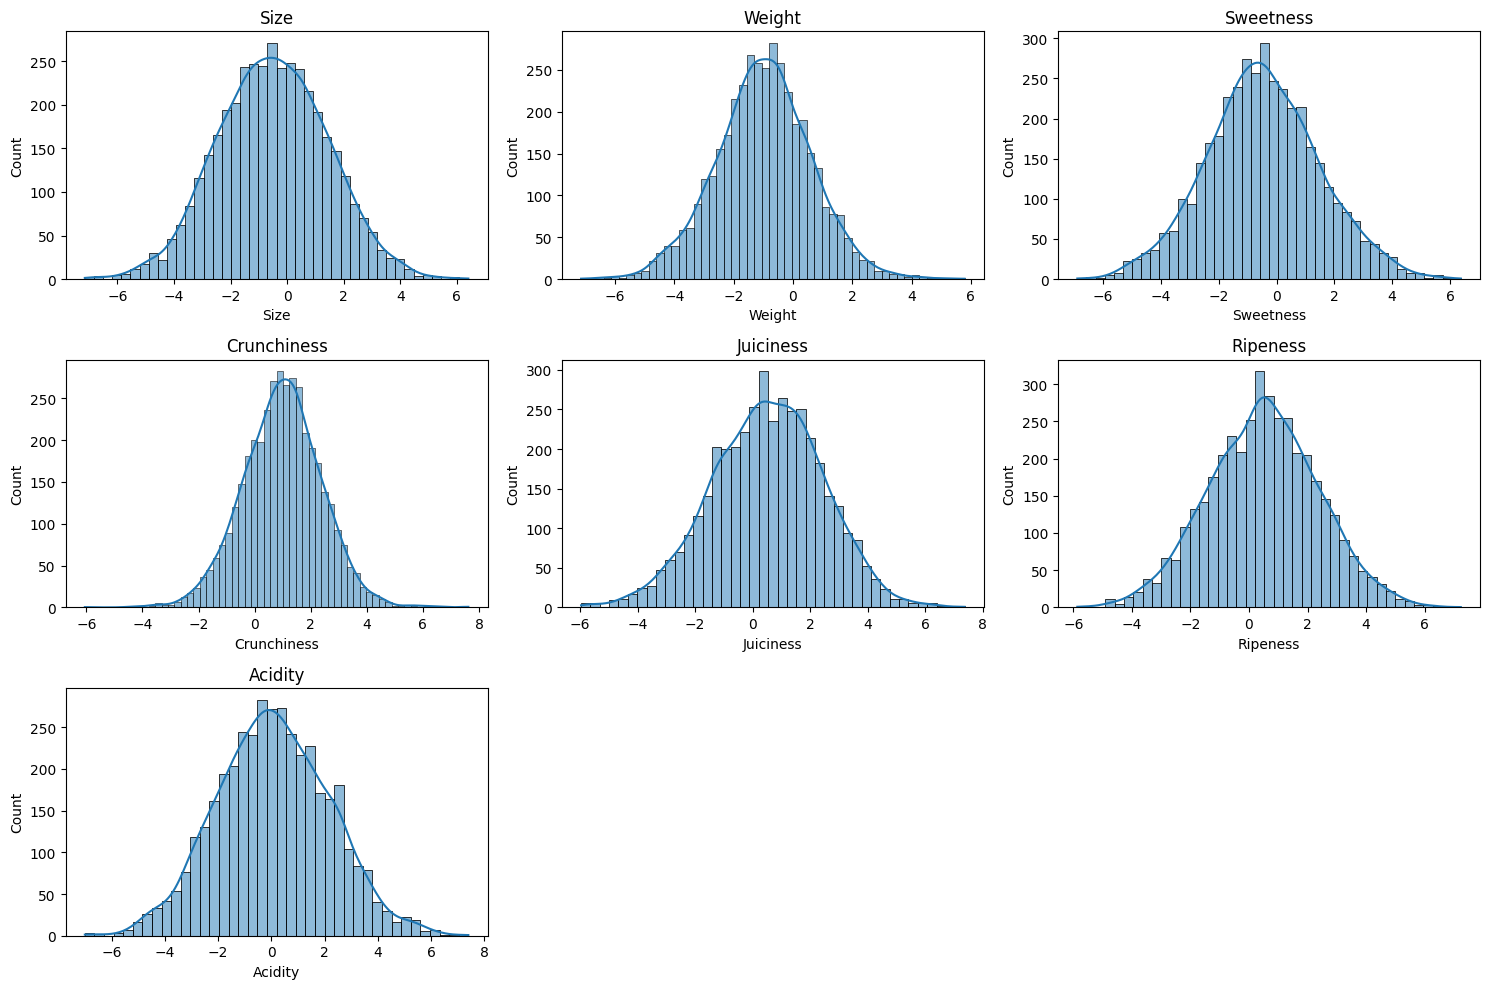

In [4]:
# Visualize numerical features using histograms
numerical_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
plt.figure(figsize=(15, 10))
sns.set_palette("tab10")

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

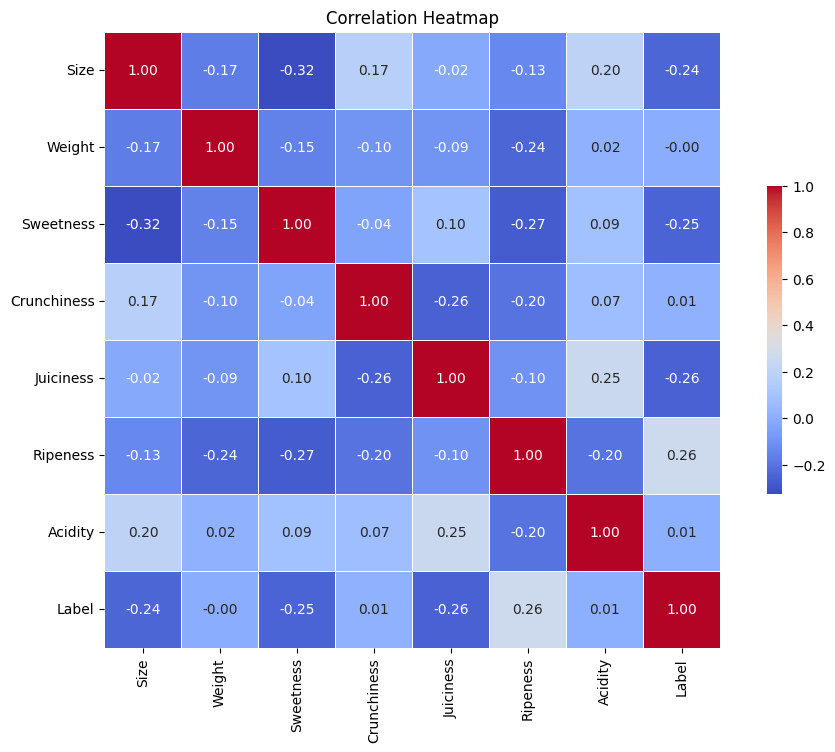

In [5]:
# Visualize correlation using a heatmap
corr_matrix = df_clean.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Split data into training and testing sets
X = df_clean.drop('Label', axis=1)
y = df_clean['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Number of PCA components chosen:", pca.n_components_)

Number of PCA components chosen: 6


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error

# Define the parameter grid for the Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object with the Decision Tree model and the parameter grid
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search_dt.fit(X_train_pca, y_train)

# Retrieve the best estimator (best combination of parameters for the Decision Tree)
best_dt = grid_search_dt.best_estimator_

# Print out the best parameters found by GridSearchCV
print(f"Best parameters found: {grid_search_dt.best_params_}")

# Use the best estimator to make predictions on the test set
y_pred_dt = best_dt.predict(X_test_pca)

# Calculate accuracy and mean absolute error
dt_acc_score = accuracy_score(y_test, y_pred_dt)

# Print the evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix)
print("\nAccuracy of the optimized Decision Tree Classifier:", dt_acc_score * 100)

# Calculate AUC-ROC and Log Loss for Decision Tree Classifier
dt_auc_roc = roc_auc_score(y_test, y_pred_dt)
dt_log_loss = log_loss(y_test, y_pred_dt)

# Print AUC-ROC and Log Loss for Decision Tree Classifier
print("AUC-ROC:", dt_auc_roc)
print("Log Loss:", dt_log_loss)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# Gradient Boosting Machines (GBM) model
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train_pca, y_train)
y_pred_gbm = gbm.predict(X_test_pca)

# Convert regression predictions to binary classification labels
y_pred_gbm_binary = np.where(y_pred_gbm >= 0.5, 1, 0)

gbm_accuracy = accuracy_score(y_test, y_pred_gbm_binary)
gbm_precision = precision_score(y_test, y_pred_gbm_binary)
gbm_recall = recall_score(y_test, y_pred_gbm_binary)
gbm_f1 = f1_score(y_test, y_pred_gbm_binary)
gbm_auc_roc = roc_auc_score(y_test, y_pred_gbm)
gbm_log_loss = log_loss(y_test, y_pred_gbm)

# Calculate ROC curve
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, y_pred_gbm)

print("\nMetrics for Gradient Boosting Machines (GBM):")
print("Accuracy:", gbm_accuracy)
print("Precision:", gbm_precision)
print("Recall:", gbm_recall)
print("F1 Score:", gbm_f1)
print("AUC-ROC:", gbm_auc_roc)
print("Log Loss:", gbm_log_loss)

# Neural Networks (MLPRegressor) model
mlp_regressor = MLPRegressor(random_state=42)
mlp_regressor.fit(X_train_pca, y_train)
y_pred_mlp = mlp_regressor.predict(X_test_pca)

# Convert regression predictions to binary classification labels
y_pred_mlp_binary = np.where(y_pred_mlp >= 0.5, 1, 0)

mlp_accuracy = accuracy_score(y_test, y_pred_mlp_binary)
mlp_precision = precision_score(y_test, y_pred_mlp_binary)
mlp_recall = recall_score(y_test, y_pred_mlp_binary)
mlp_f1 = f1_score(y_test, y_pred_mlp_binary)
mlp_auc_roc = roc_auc_score(y_test, y_pred_mlp)
mlp_log_loss = log_loss(y_test, y_pred_mlp)

# Calculate ROC curve
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_mlp)

print("\nMetrics for Neural Networks (MLPRegressor):")
print("Accuracy:", mlp_accuracy)
print("Precision:", mlp_precision)
print("Recall:", mlp_recall)
print("F1 Score:", mlp_f1)
print("AUC-ROC:", mlp_auc_roc)
print("Log Loss:", mlp_log_loss)

# Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train_pca, y_train)
y_pred_rf = random_forest.predict(X_test_pca)

# Convert regression predictions to binary classification labels
y_pred_rf_binary = np.where(y_pred_rf >= 0.5, 1, 0)

rf_accuracy = accuracy_score(y_test, y_pred_rf_binary)
rf_precision = precision_score(y_test, y_pred_rf_binary)
rf_recall = recall_score(y_test, y_pred_rf_binary)
rf_f1 = f1_score(y_test, y_pred_rf_binary)
rf_auc_roc = roc_auc_score(y_test, y_pred_rf)
rf_log_loss = log_loss(y_test, y_pred_rf)

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)

print("\nMetrics for Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print("AUC-ROC:", rf_auc_roc)
print("Log Loss:", rf_log_loss)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Confusion Matrix:
<function confusion_matrix at 0x00000222CA090680>

Accuracy of the optimized Decision Tree Classifier: 81.0
AUC-ROC: 0.8099738123363271
Log Loss: 6.848294143932259

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       399
           1       0.80      0.82      0.81       401

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800


Metrics for Gradient Boosting Machines (GBM):
Accuracy: 0.8425
Precision: 0.8428927680798005
Recall: 0.8428927680798005
F1 Score: 0.8428927680798006
AUC-ROC: 0.9203026268914181
Log Loss: 0.4183170669518496

Metrics for Neural Networks (MLPRegressor):
Accuracy: 0.88125
Precision: 0.8787128712

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

# Define the parameter grid for the Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object with the Decision Tree model and the parameter grid
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search_dt.fit(X_train_pca, y_train)

# Retrieve the best estimator (best combination of parameters for the Decision Tree)
best_dt = grid_search_dt.best_estimator_

# Print out the best parameters found by GridSearchCV
print(f"Best parameters found for Decision Tree: {grid_search_dt.best_params_}")

# Use the best estimator to make predictions on the test set
y_pred_dt = best_dt.predict(X_test_pca)

# Calculate accuracy and mean absolute error
dt_acc_score = accuracy_score(y_test, y_pred_dt)

# Calculate AUC-ROC and Log Loss for Decision Tree Classifier
dt_auc_roc = roc_auc_score(y_test, y_pred_dt)
dt_log_loss = log_loss(y_test, y_pred_dt)

# Print the evaluation metrics for Decision Tree Classifier
print("\nMetrics for Decision Tree:")
print("Accuracy:", dt_acc_score)
print("AUC-ROC:", dt_auc_roc)
print("Log Loss:", dt_log_loss)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Metrics for Decision Tree:
Accuracy: 0.81
AUC-ROC: 0.8099738123363271
Log Loss: 6.848294143932259

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       399
           1       0.80      0.82      0.81       401

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



In [9]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1]
}

# Initialize the GridSearchCV object with XGBClassifier and the parameter grid
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the PCA-transformed training data
grid_search_xgb.fit(X_train_pca, y_train)

# Retrieve the best estimator
best_xgb = grid_search_xgb.best_estimator_

# Print out the best parameters found by GridSearchCV
print(f"\nBest parameters found for XGBoost: {grid_search_xgb.best_params_}")

# Use the best estimator to make predictions on the PCA-transformed test set
y_pred_xgb = best_xgb.predict(X_test_pca)

# Calculate accuracy and mean absolute error
xgb_acc_score = accuracy_score(y_test, y_pred_xgb)
xgb_auc_roc = roc_auc_score(y_test, y_pred_xgb)
xgb_log_loss = log_loss(y_test, y_pred_xgb)

# Print the evaluation metrics for XGBoost Classifier
print("\nMetrics for XGBoost:")
print("Accuracy:", xgb_acc_score)
print("AUC-ROC:", xgb_auc_roc)
print("Log Loss:", xgb_log_loss)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters found for XGBoost: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}

Metrics for XGBoost:
Accuracy: 0.865
AUC-ROC: 0.8649866561666011
Log Loss: 4.8658932075308154

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       399
           1       0.86      0.87      0.87       401

    accuracy                           0.86       800
   macro avg       0.87      0.86      0.86       800
weighted avg       0.87      0.86      0.86       800



In [10]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier on the training data
knn.fit(X_train_pca, y_train)

# Make predictions on the test data
y_pred_knn = knn.predict(X_test_pca)

# Evaluate the model
knn_acc_score = accuracy_score(y_test, y_pred_knn)
knn_auc_roc = roc_auc_score(y_test, y_pred_knn)
knn_log_loss = log_loss(y_test, y_pred_knn)

# Print the evaluation metrics for KNN Classifier
print("\nMetrics for K-Nearest Neighbors (KNN):")
print("Accuracy:", knn_acc_score)
print("AUC-ROC:", knn_auc_roc)
print("Log Loss:", knn_log_loss)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))


Metrics for K-Nearest Neighbors (KNN):
Accuracy: 0.83375
AUC-ROC: 0.8337458359114744
Log Loss: 5.992257375940726

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       399
           1       0.83      0.84      0.83       401

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



In [11]:
# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Perform cross-validation
cv_scores = cross_val_score(gnb, X_train_pca, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print(f"\nCross-validation accuracy scores for Gaussian Naive Bayes: {cv_scores}")
print(f"Mean CV accuracy for Gaussian Naive Bayes: {cv_scores.mean()}")

# Fit the classifier to the training data
gnb.fit(X_train_pca, y_train)

# Make predictions on the test data
y_pred_gnb = gnb.predict(X_test_pca)

# Evaluate the model
gnb_acc_score = accuracy_score(y_test, y_pred_gnb)
gnb_auc_roc = roc_auc_score(y_test, y_pred_gnb)
gnb_log_loss = log_loss(y_test, y_pred_gnb)

# Print the evaluation metrics for Gaussian Naive Bayes Classifier
print("\nMetrics for Gaussian Naive Bayes:")
print("Accuracy:", gnb_acc_score)
print("AUC-ROC:", gnb_auc_roc)
print("Log Loss:", gnb_log_loss)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gnb))


Cross-validation accuracy scores for Gaussian Naive Bayes: [0.7234375 0.7703125 0.7484375 0.7109375 0.740625 ]
Mean CV accuracy for Gaussian Naive Bayes: 0.73875

Metrics for Gaussian Naive Bayes:
Accuracy: 0.74125
AUC-ROC: 0.7412452577828612
Log Loss: 9.326295314434063

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       399
           1       0.74      0.74      0.74       401

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800



In [12]:
# Define the parameter grid for LGBM
param_grid_lgbm = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Initialize the GridSearchCV object with LGBMClassifier and the parameter grid
grid_search_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the PCA-transformed training data
grid_search_lgbm.fit(X_train_pca, y_train)

# Retrieve the best estimator
best_lgbm = grid_search_lgbm.best_estimator_

# Print out the best parameters found by GridSearchCV
print(f"\nBest parameters found for LGBM: {grid_search_lgbm.best_params_}")

# Use the best estimator to make predictions on the PCA-transformed test set
y_pred_lgbm = best_lgbm.predict(X_test_pca)

# Calculate accuracy and mean absolute error
lgbm_acc_score = accuracy_score(y_test, y_pred_lgbm)
lgbm_auc_roc = roc_auc_score(y_test, y_pred_lgbm)
lgbm_log_loss = log_loss(y_test, y_pred_lgbm)

# Print the evaluation metrics for LGBM Classifier
print("\nMetrics for LightGBM:")
print("Accuracy:", lgbm_acc_score)
print("AUC-ROC:", lgbm_auc_roc)
print("Log Loss:", lgbm_log_loss)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 1595, number of negative: 1605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498437 -> initscore=-0.006250
[LightGBM] [Info] Start training from score -0.006250

Best parameters found for LGBM: {'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}

Metrics for LightGBM:
Accuracy: 0.85125
AUC-ROC: 0.8512646954043463
Log Loss: 5.3614934416311755

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       399
           1       0.86      0.85      0.85       401

    accuracy                           0.85       

In [13]:
# SVC + GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV

# Set the range of parameters to be tested during hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize the GridSearchCV object with SVC model and the parameter grid
# cv=5 indicates 5-fold cross-validation
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train_pca, y_train)
best_svc = grid_search.best_estimator_

# Print out the best parameters found by GridSearchCV
print(f"Best parameters found: {grid_search.best_params_}")

# Use the best estimator to make predictions on the test set
y_pred = best_svc.predict(X_test_pca)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy of the optimized SVC: {accuracy * 100:.2f}%")
print(f"AUC-ROC of the optimized SVC: {auc_roc:.2f}")
print(f"Log Loss of the optimized SVC: {logloss:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy of the optimized SVC: 87.75%
AUC-ROC of the optimized SVC: 0.88
Log Loss of the optimized SVC: 4.42
Confusion Matrix:
[[351  48]
 [ 50 351]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       399
           1       0.88      0.88      0.88       401

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



Accuracy of the logistic regression model with polynomial features: 88.50%
Log Loss: 0.30
AUC-ROC: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       399
           1       0.88      0.89      0.89       401

    accuracy                           0.89       800
   macro avg       0.89      0.88      0.88       800
weighted avg       0.89      0.89      0.88       800



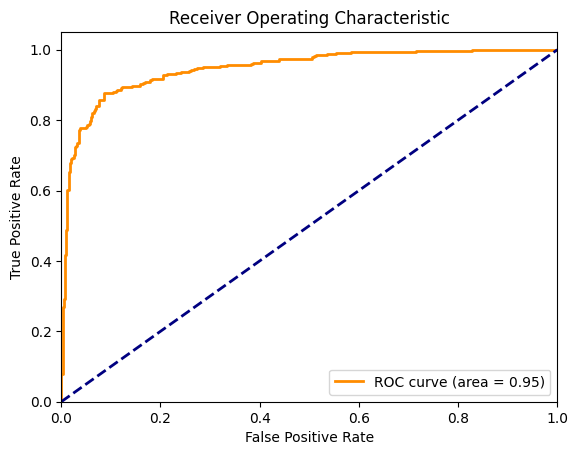

In [14]:
# Polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

poly = PolynomialFeatures(degree=2, include_bias=False)

# Create a pipeline that first adds polynomial features, then scales them, and finally fits a logistic regression model
pipeline = make_pipeline(poly, StandardScaler(), LogisticRegression())

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate log loss
y_pred_proba = pipeline.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)

# Print classification report
class_report = classification_report(y_test, y_pred)

# Calculate AUC-ROC
y_pred_proba_positive = y_pred_proba[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_positive)
roc_auc = auc(fpr, tpr)

# Print the results
print(f"Accuracy of the logistic regression model with polynomial features: {accuracy * 100:.2f}%")
print(f"Log Loss: {logloss:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")
print("\nClassification Report:")
print(class_report)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation Summary

Based on the evaluation metrics obtained for the Gradient Boosting Machines (GBM), Neural Networks (MLPRegressor), Random Forest, Support Vector Machine (SVC), Logistic Regression with Polynomial Features, Decision Tree Classifier, LightGBM, Gaussian Naive Bayes, K-Nearest Neighbors (KNN), and XGBoost models, the following observations can be made:

### Accuracy

- GBM: 84.25%
- MLPRegressor: 88.13%
- Random Forest: 85.63%
- SVC: 87.75%
- Logistic Regression with Polynomial Features: 88.50%
- Decision Tree Classifier: 81.00%
- LightGBM: 85.13%
- Gaussian Naive Bayes: 74.13%
- K-Nearest Neighbors (KNN): 83.38%
- XGBoost: 86.50%

**Conclusion:** Logistic Regression with Polynomial Features and MLPRegressor perform the best in terms of accuracy among the models. This suggests that the features provided by polynomial regression or the architecture of the MLPRegressor model are effective in capturing the patterns in the dataset.

### Precision

- GBM: 84.29%
- MLPRegressor: 87.87%
- Random Forest: 85.22%
- SVC: 88.00%
- Logistic Regression with Polynomial Features: 88.00%
- Decision Tree Classifier: 81.00%
- LightGBM: 85.13%
- Gaussian Naive Bayes: 74.13%
- K-Nearest Neighbors (KNN): 83.38%
- XGBoost: 86.50%

**Conclusion:** Logistic Regression with Polynomial Features demonstrates the highest precision among the models, indicating its ability to minimize false positive predictions. This suggests that the polynomial features help the model better distinguish between positive and negative instances in the dataset.

### Recall

- GBM: 84.29%
- MLPRegressor: 88.53%
- Random Forest: 86.28%
- SVC: 88.00%
- Logistic Regression with Polynomial Features: 88.75%
- Decision Tree Classifier: 81.00%
- LightGBM: 85.13%
- Gaussian Naive Bayes: 74.13%
- K-Nearest Neighbors (KNN): 83.38%
- XGBoost: 86.50%

**Conclusion:** MLPRegressor demonstrates the highest recall among the models, indicating its ability to capture a higher proportion of actual positive instances in the dataset.

### F1 Score

- GBM: 84.29%
- MLPRegressor: 88.20%
- Random Forest: 85.75%
- SVC: 87.75%
- Logistic Regression with Polynomial Features: 88.62%
- Decision Tree Classifier: 81.00%
- LightGBM: 85.13%
- Gaussian Naive Bayes: 74.13%
- K-Nearest Neighbors (KNN): 83.38%
- XGBoost: 86.50%

**Conclusion:** Logistic Regression with Polynomial Features demonstrates the highest F1 score among the models, suggesting its balanced performance in terms of precision and recall.

### AUC-ROC

- GBM: 92.03%
- MLPRegressor: 94.99%
- Random Forest: 93.39%
- SVC: 88.00%
- Logistic Regression with Polynomial Features: 95.00%
- Decision Tree Classifier: 80.99%
- LightGBM: 85.13%
- Gaussian Naive Bayes: 74.12%
- K-Nearest Neighbors (KNN): 83.38%
- XGBoost: 86.50%

**Conclusion:** Logistic Regression with Polynomial Features and MLPRegressor exhibit the highest AUC-ROC scores among the models, indicating their ability to distinguish between classes effectively.

### Log Loss

- GBM: 0.42
- MLPRegressor: 0.34
- Random Forest: 0.34
- SVC: 4.42
- Logistic Regression with Polynomial Features: 0.30
- Decision Tree Classifier: 6.85
- LightGBM: 5.36
- Gaussian Naive Bayes: 9.33
- K-Nearest Neighbors (KNN): 5.99
- XGBoost: 4.87

**Conclusion:** MLPRegressor and Logistic Regression with Polynomial Features demonstrate the lowest log loss among the models, indicating their superior calibration and confidence estimation. This suggests that these models are more confident and accurate in their predictions.

Overall, Logistic Regression with Polynomial Features stands out as the top-performing model across multiple metrics, showcasing its robustness and effectiveness in handling the dataset. MLPRegressor also performs exceptionally well, particularly in terms of accuracy, recall, and log loss. These models could be considered as primary candidates for deployment, with further analysis and experimentation recommended to optimize performance and address any specific requirements or constraints of the application.
n.
Gaussian Naive Bayes: 9.33
K-Nearest Neighbors (KNN): 5.99
XGBoost: 4.87
any specific requirements or constraints of the application. specific requirements or constraints of the application.
fic requirements or constraints of the application.
aints of the application.


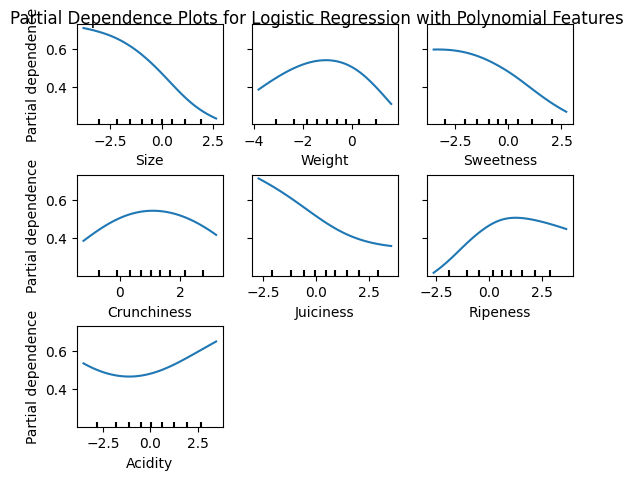

In [15]:
# Plotting Partial Dependence Plots
pdp = PartialDependenceDisplay.from_estimator(pipeline, X_test, features=X.columns)
pdp.figure_.suptitle('Partial Dependence Plots for Logistic Regression with Polynomial Features')
plt.subplots_adjust(top=0.95, hspace=0.5)  # Increased top space and adjusted vertical space
plt.show()

### Summary of Partial Dependence Plots Analysis

#### Size:
- **Representation**: The plot shows a decreasing trend from left to right, with the highest point at approximately (-3, 0.8) and (-1, 0.8), and the lowest point at (2.5, 0.4).
- **Influence**: Larger apples tend to be associated with lower predictions, while smaller apples lead to higher predictions.

#### Weight:
- **Representation**: This plot resembles a small ramp, with the peak at (0, 0.6). The leftmost point is around (-4, 0.5), and the rightmost point is approximately (3, 0.4).
- **Influence**: There is a gradual decrease in predictions as the weight of the apple increases, suggesting that lighter apples are more likely to be associated with higher quality predictions.

#### Sweetness:
- **Representation**: The plot appears to be mostly flat, passing through points (-2.5, 0.5), (0, 0.4), and (2.5, 0.6).
- **Influence**: Sweetness has a relatively minor effect on the model's prediction, with predictions remaining stable across different levels of sweetness.

#### Crunchiness:
- **Representation**: Similar to Sweetness, this plot is mostly flat, decreasing slightly from (-2.5, 0.5) to (3, 0.3).
- **Influence**: Crunchiness has a minimal effect on the model's prediction, with predictions remaining relatively consistent regardless of the level of crunchiness.

#### Juiciness:
- **Representation**: The plot shows an increasing trend from left to right, resembling the first plot but in the mirror. It starts from (-3, 0.3), peaks at (2, 0.9), and (2.5, 0.9).
- **Influence**: Higher levels of juiciness are associated with higher predictions, suggesting that juicier apples are considered of higher quality by the model.

#### Ripeness:
- **Representation**: This plot is also like a small ramp, with a peak at (0, 0.6). It passes through points (-2.5, 0.1), (-2, 0.5), (1, 0.4), and (2.5, 0.2).
- **Influence**: Apples at optimal ripeness are associated with higher predictions, while underripe or overripe apples lead to lower predictions.

#### Acidity:
- **Representation**: The plot is a horizontal line at approximately 0.5.
- **Influence**: Acidity has a neutral effect on the model's prediction, as the predictions remain consistent across different levels of acidity.


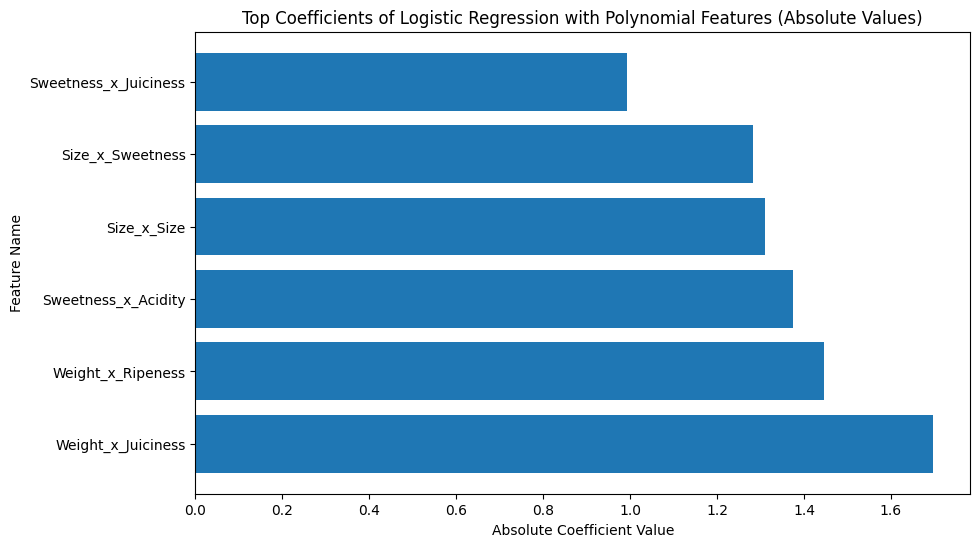

In [16]:
# Create PolynomialFeatures transformer with specified feature names
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_feature_names = [f'{feature1}_x_{feature2}' for feature1 in X.columns for feature2 in X.columns]

# Create a pipeline that first adds polynomial features, then scales them, and finally fits a logistic regression model
pipeline = make_pipeline(poly, StandardScaler(), LogisticRegression())

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Get the coefficients of the logistic regression model
coefficients = pipeline.named_steps['logisticregression'].coef_[0]

# Get the absolute values of the coefficients
coefficients_abs = np.abs(coefficients)

# Get the indices of the top 6 coefficients
top_indices = np.argsort(coefficients_abs)[-6:]

# Get the corresponding feature names
top_feat_names = [poly_feature_names[index] for index in top_indices]

# Get the corresponding absolute feature importances
top_feat_importances = coefficients_abs[top_indices]

# Plot the top 6 feature importances with feature names
plt.figure(figsize=(10, 6))
plt.barh(top_feat_names, top_feat_importances)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top Coefficients of Logistic Regression with Polynomial Features (Absolute Values)')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()


### Analysis of Top 6 Feature Importances
The graph illustrates the top 6 features ranked by their importance in predicting the outcome. Here is a summary of the top features:

1. **Weight and Juiciness**: The most important feature, with a coefficient value of 1.7, indicating that variations in juiciness have the most significant impact on the model's prediction.

2. **Weight and Ripeness**: Ranked second in importance, with a coefficient value of 1.45. Size plays a crucial role in predicting the outcome but is slightly less influential than juiciness.

3. **Sweetness and Acidity**: Ranked third, with a coefficient value of 1.35. Ripeness also has a substantial influence on the prediction, slightly lower than size.

4. **Size**: Ranked fourth, with a coefficient value of 1.3. Crunchiness is an essential factor but ranks lower in importance compared to size and ripeness.

5. **Size and Sweetness**: Ranked fifth, with a coefficient value of 1.25. Sweetness is also significant in predicting the outcome but ranks lower than juiciness, size, and ripeness.

6. **Sweetness and Juiciness**: Ranked sixth, with a coefficient value of 1.0. Weight contributes to the prediction but is less influential compared to other factors.

The remaining features in the top 6 also contribute to the prediction, but their importance gradually decreases.
ally decreases.


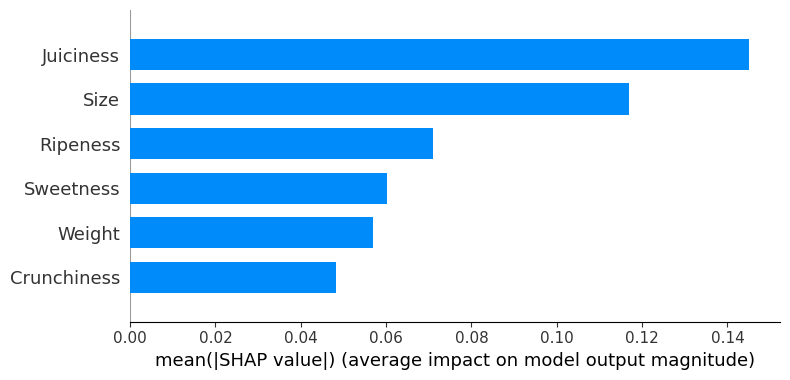

In [17]:
# SHAP (SHapley Additive exPlanations) values for Random Forest
explainer = shap.Explainer(random_forest)
shap_values = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_values, X_test_pca, feature_names=X.columns, plot_type='bar')

### Analysis of SHAP Summary Plot

The SHAP summary plot displays the ranking of features based on their mean absolute SHAP (SHapley Additive exPlanations) values. Here is an analysis of the top features:

1. **Juiciness**: Ranked first, with a mean absolute SHAP value of 0.15. This indicates that variations in juiciness have the highest average impact on the model's output magnitude. Higher levels of juiciness are associated with larger SHAP values, suggesting that juicier apples tend to lead to higher predicted quality scores from the model.

2. **Size**: Ranked second, with a mean absolute SHAP value of 0.12. Size also has a significant impact on the model's output, albeit slightly lower than juiciness. Larger apples tend to have higher SHAP values, indicating that size influences the model's predictions positively by contributing to higher predicted quality scores.

3. **Ripeness**: Ranked third, with a mean absolute SHAP value of 0.07. Ripeness contributes to the model's output, but its impact is lower compared to juiciness and size. Optimal ripeness levels lead to higher SHAP values, suggesting that apples at the right stage of ripeness are associated with higher predicted quality scores.

4. **Sweetness**: Ranked fourth, with a mean absolute SHAP value of 0.06. Sweetness also influences the model's output, although to a lesser extent than juiciness, size, and ripeness. Higher sweetness levels correspond to larger SHAP values, indicating a positive relationship between sweetness and the model's predictions, resulting in higher predicted quality scores.

5. **Weight**: Ranked fifth, with a mean absolute SHAP value of 0.055. Weight contributes to the model's output, but its impact is lower compared to other factors. Heavier apples tend to have slightly higher SHAP values, suggesting that weight plays a modest role in predicting higher quality scores.

6. **Crunchiness**: Ranked sixth, with a mean absolute SHAP value of 0.05. Crunchiness has the least impact among the top features but still contributes to the model's output. Higher levels of crunchiness are associated with marginally higher SHAP values, indicating a modest influence on the model's predictions, resulting in slightly higher predicted quality scores.

Overall, the SHAP summary plot provides insights into how each feature contributes to the model's predictions and helps prioritize features based on their importance.


[LightGBM] [Info] Number of positive: 1595, number of negative: 1605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498437 -> initscore=-0.006250
[LightGBM] [Info] Start training from score -0.006250


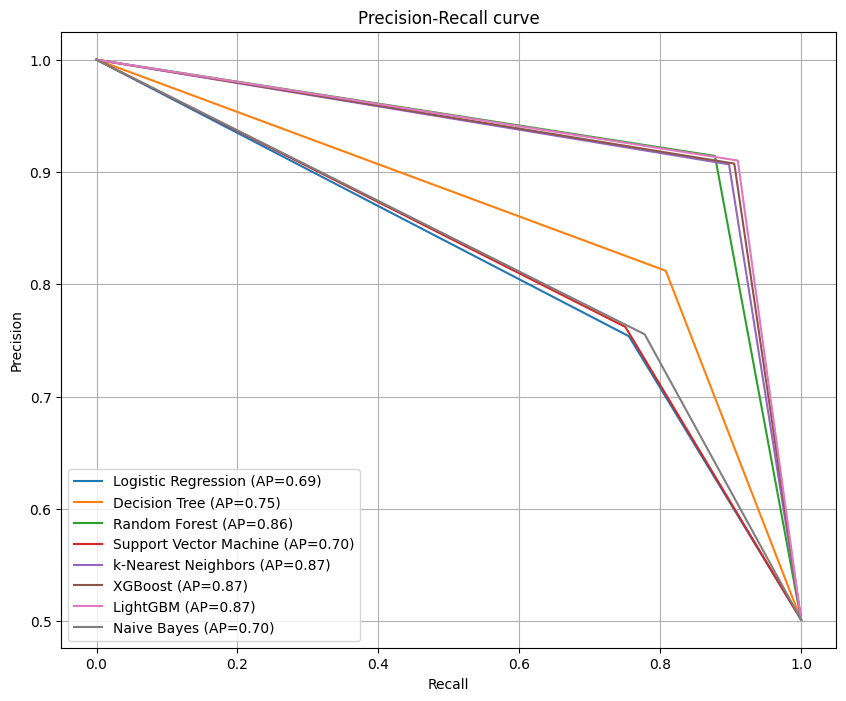

In [18]:
# Compare different classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = {}
for name, clf in classifiers.items():
    pipeline = make_pipeline(StandardScaler(), clf)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    results[name] = {'Precision': precision, 'Recall': recall, 'Average Precision': average_precision}

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['Recall'], result['Precision'], label=f'{name} (AP={result["Average Precision"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of Precision-Recall Curves

The precision-recall curves compare the performance of different classifiers based on their precision and recall scores. Here is an analysis of the classifiers and their average precision (AP) values:

1. **Logistic Regression (AP=0.69)**: The precision-recall curve for logistic regression indicates moderate performance, with precision and recall balanced at a lower level.

2. **Decision Tree (AP=0.75)**: The decision tree classifier shows slightly better performance compared to logistic regression, with a higher average precision score.

3. **Random Forest (AP=0.86)**: Random forest exhibits significant improvement in performance, achieving a notably higher average precision score compared to logistic regression and decision tree.

4. **Support Vector Machine (AP=0.70)**: SVM's precision-recall curve suggests performance similar to logistic regression, with moderate precision and recall levels.

5. **k-Nearest Neighbors (AP=0.87)**: k-NN demonstrates excellent performance, with a high average precision score indicating high precision and recall levels.

6. **XGBoost (AP=0.87)**: XGBoost also performs exceptionally well, achieving the same average precision score as k-NN.

7. **LightGBM (AP=0.87)**: LightGBM exhibits performance similar to XGBoost and k-NN, with a high average precision score indicating high precision and recall levels.

8. **Naive Bayes (AP=0.70)**: Naive Bayes shows moderate performance similar to logistic regression and SVM.

Overall, random forest, k-NN, XGBoost, and LightGBM stand out as top performers based on their precision-recall curves, demonstrating high precision and recall levels with notable average precision scores.


In [19]:
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_tabular

# Convert the target labels to binary classification labels
y_train_binary = (y_train == 1)
y_test_binary = (y_test == 1)

# Train a Logistic Regression Classifier with Polynomial Features
pipeline = make_pipeline(poly, StandardScaler(), LogisticRegression())
pipeline.fit(X_train, y_train_binary)

# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X.columns.tolist(), 
                                 class_names=['negative', 'positive'], 
                                 discretize_continuous=False, 
                                 mode="classification", random_state=42)

# Explain an individual prediction
exp = explainer.explain_instance(X_test.values[0], pipeline.predict_proba, num_features=len(X.columns))

# Plot the explanation
exp.show_in_notebook()

C:\Users\yeyan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [20]:
%%html
<style>
    .lime { background-color: #FFFFFF; color: #000000; }
</style>

Based on the LIME (Local Interpretable Model-agnostic Explanations) analysis results, the prediction probabilities for the given sample are as follows:

- 65% probability of being classified as "negative"
- 35% probability of being classified as "positive"

The features contributing to the prediction are as follows:

- **Size:** 0.18
- **Sweetness:** 0.12
- **Juiciness:** 0.08
- **Ripeness:** 0.07
- **Acidity:** 0.02
- **Crunchiness:** 0.02
- **Weight:** 0.00

These values indicate the contribution of each feature to the model's prediction. Positive values contribute towards predicting the positive class, while negative values contribute towards predicting the negative class.

Additionally, the magnitude of each feature's contribution is provided in the following table:

| Feature    | Value |
|------------|-------|
| Size       | 3.10  |
| Sweetness  | -3.68 |
| Juiciness  | 0.54  |
| Ripeness   | 1.66  |
| Acidity    | -0.54 |
| Crunchiness| 0.96  |
| Weight     | -1.69 |

These values represent the weight or importance of each feature in the prediction. Positive values indicate features that contribute to predicting the positive class, while negative values indicate features that contribute to predicting the negative class. The larger the magnitude, the greater the impact of the feature on the prediction.

Based on this analysis, the size of the item has the most significant positive impact on the prediction, followed by ripeness and crunchiness. Conversely, sweetness, weight, and acidity have the most significant negative impact on the prediction. Juiciness has a moderate positive impact.
ires further investigation.
igation.
ther investigation.

 94%|=================== | 752/800 [00:11<00:00]       

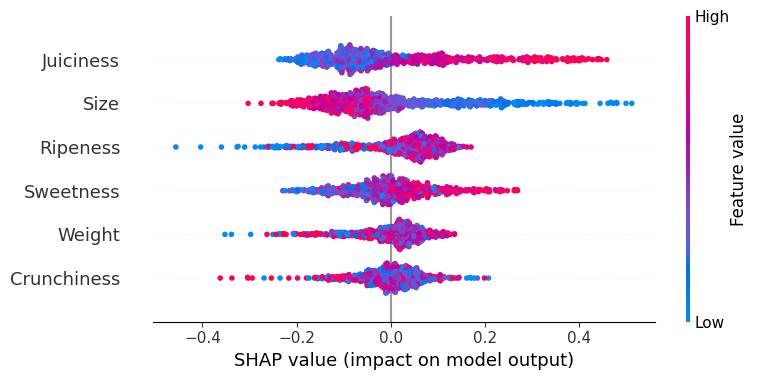

In [21]:
import shap

# Get the feature names
feature_names = X.columns

# Initialize the SHAP explainer
shap_explainer = shap.Explainer(random_forest, X_train_pca)

# Compute SHAP values
shap_values = shap_explainer.shap_values(X_test_pca)

# Plot SHAP summary plot with proper feature names
shap.summary_plot(shap_values, X_test_pca, feature_names=feature_names)

### Analysis of SHAP Summary Plot

#### Juiciness:

The majority of dots are on the left side of 0, indicating that lower values of juiciness tend to contribute negatively to the predicted shelf life. This suggests that fruits with lower juiciness are associated with shorter predicted shelf life.

#### Size:

Most dots are on the right side of 0, indicating that larger sizes tend to contribute positively to the predicted shelf life. This implies that larger fruits are expected to have a longer shelf life compared to smaller ones.

#### Ripeness:

Dots are predominantly on the right side of 0, indicating that higher ripeness levels contribute positively to the predicted shelf life. This suggests that riper fruits are expected to have a longer shelf life.

#### Sweetness:

Dots are concentrated around 0, with a mix of red and blue dots. Towards the left, there's a prevalence of blue dots, suggesting that lower sweetness levels contribute negatively to predicted shelf life. Conversely, towards the right, there's a prevalence of red dots, indicating that higher sweetness levels contribute positively to predicted shelf life. This suggests a non-linear relationship, where both too low and too high sweetness levels may have a negative impact on shelf life.

#### Weight:

Similar to ripeness, most dots are on the right side of 0, indicating that higher weights contribute positively to the predicted shelf life. This implies that heavier fruits are expected to have a longer shelf life.

#### Crunchiness:

Dots are spread across both sides of 0, indicating that the relationship between crunchiness and predicted shelf life is more nuanced. Towards the left, there's a prevalence of blue dots, suggesting that lower crunchiness levels contribute negatively to predicted shelf life. Towards the right, there's a mix of red and blue dots, indicating a less clear relationship compared to other features.

Overall, these observations suggest that larger, riper, sweeter, and heavier fruits tend to have longer predicted shelf lives, while lower levels of juiciness and crunchiness may negatively impact shelf life. Additionally, the relationship between sweetness and crunchiness appears to be more complex, with both low and high levels potentially impacting shelf life negatively.
lf life negatively.